# If-else is crucial in programming

Your daily python programs can execute commands:
- sequentially
- parallelly, sync or asynchronously
- conditionally

A graph in LangGraph is no different. We saw how nodes can be invoked sequentially in the feeling-hot-chill example in branch b01.

In this notebook, we see how LangGraph implement conditionality

# Create a coin-toss game

<div>
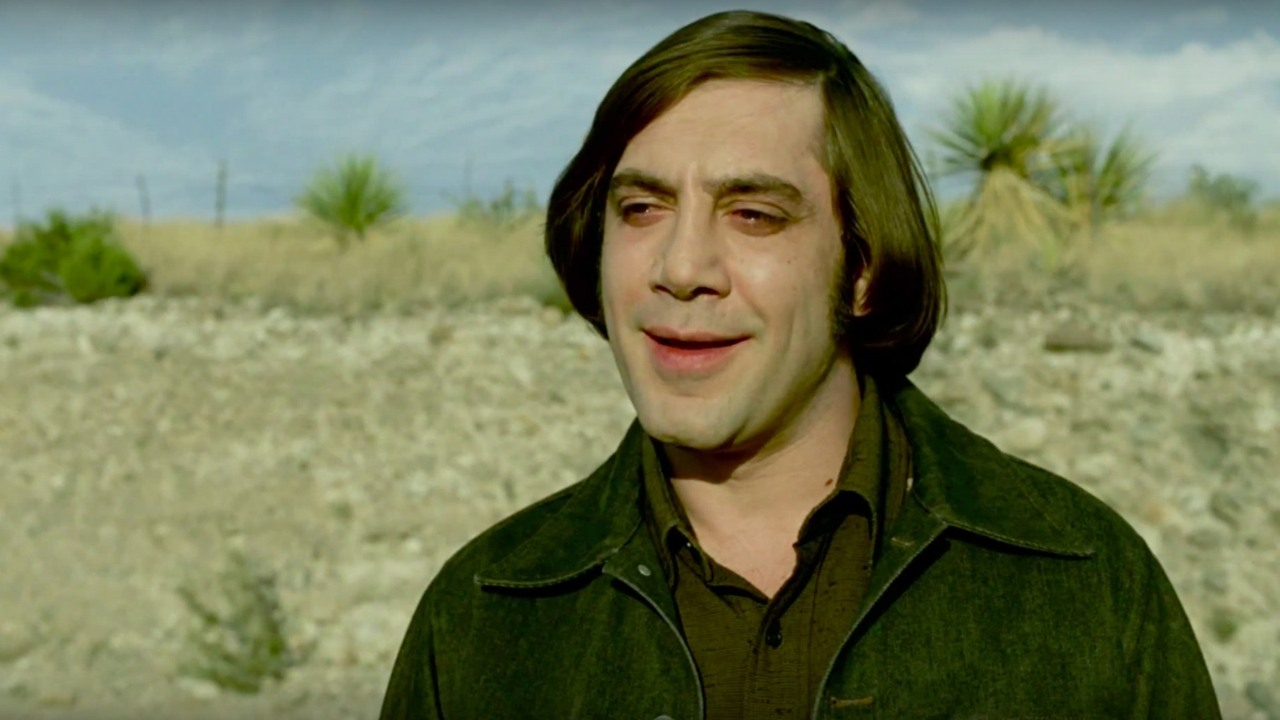
</div>

Our coin-toss game graph will be like this:
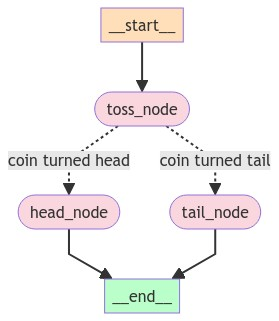

End user will see something like this
```
User: head
Assistant: {'coin_face': 'head'}
Assistant: {'message': 'You lived'}
User: tail
Assistant: {'coin_face': 'tail'}
Assistant: {'message': 'You lived'}
User: harry porter
Assistant: {'coin_face': 'tail'}
Assistant: {'message': 'You die'}
User: q
Goodbye!
```

In [101]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import random


class State(TypedDict):
    coin_face: str
    message: str
    user_pick: str

        
def coin_fn(state: State):
    return {"coin_face": random.choice(['head', 'tail'])}

def head_fn(state: State):
    if state['user_pick'] == 'head':
        return {"message": "You lived"}
    return {"message": "You die"}

def tail_fn(state: State):
    if state['user_pick'] == 'tail':
        return {"message": "You lived"}
    return {"message": "You die"}

In [102]:
graph_builder = StateGraph(State)

graph_builder.add_node("toss_node", coin_fn)
graph_builder.add_node("head_node", head_fn)
graph_builder.add_node("tail_node", tail_fn)

graph_builder.add_edge(START, "toss_node")
graph_builder.add_edge("head_node", END)
graph_builder.add_edge("tail_node", END)

# Routers

We are already familiar with the core components: state, nodes, edges. The missing piece is a router

A router that can, based on the outcome of `toss_node`, route the flow to either `head_node` or `tail_node`. 

The router object, therefore, must use state as input, and output a node name. In LangGraph we implement this as a function.

In [104]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the head_node if the 
    coin turned head, otherwise, route to the tail_node
    """
    if state['coin_face'] == 'head':
        return 'head_node'
    else:
        return 'tail_node'


In [105]:
graph_builder.add_conditional_edges("toss_node", route_tools)

graph = graph_builder.compile()

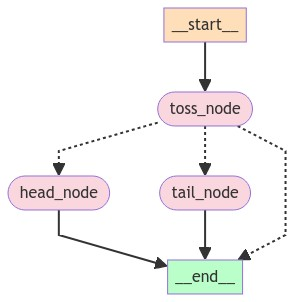

In [107]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [91]:
while True:
    # Pepertually asks for input
    user_input = input("User: ")
    
    # Exit mechanism (totally mannual)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
        
        
    for event in graph.stream({"user_pick": user_input}):
        for value in event.values():
            print("Assistant:", value)

User: head
Assistant: {'coin_face': 'head'}
Assistant: {'message': 'You lived'}
User: tail
Assistant: {'coin_face': 'tail'}
Assistant: {'message': 'You lived'}
User: harry porter
Assistant: {'coin_face': 'tail'}
Assistant: {'message': 'You die'}
User: q
Goodbye!


For some reason, our graph visualization shows an extra edge from `toss_node` to `__end__`. 

(Probably was added by LangGraph by default?)

To recreate the exact graph visual we visioned at the start of this notebook, use a dict to map output of the routing function to the corresponding name:

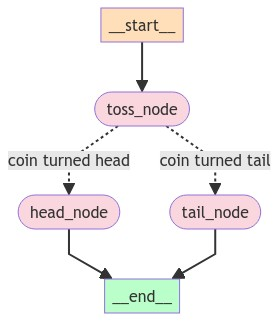

In [117]:
graph_builder = StateGraph(State)

graph_builder.add_node("toss_node", coin_fn)
graph_builder.add_node("head_node", head_fn)
graph_builder.add_node("tail_node", tail_fn)

graph_builder.add_edge(START, "toss_node")
graph_builder.add_edge("head_node", END)
graph_builder.add_edge("tail_node", END)


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the head_node if the 
    coin turned head, otherwise, route to the tail_node
    """
    if state['coin_face'] == 'head':
        return 'coin turned head'
    else:
        return 'coin turned tail'
    
graph_builder.add_conditional_edges("toss_node",
                                    route_tools,
                                    {'coin turned head': 'head_node', 'coin turned tail': 'tail_node'}
                                   )

graph = graph_builder.compile()


try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

Notice how router's effect is visualized as dotted lines

# Conditional entry point

https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-entry-point

Depends on your use case, you may want `__start__` to `toss_node` to be conditional, also use `add_conditional_edges`.


# Conclusion

We successfully implemented conditionality in graph.

In b01, we briefly mentioned history implementation. We will go over this idea in the next branch.